## Pharmacokinetic Modelling of Drug Concentrations with Ordinary Differential Equations (ODE) and Differential Evolution (DE)

**Motivation**  
I explored pharmacokinetic (PK) modelling for drug concentration trajectories as part of a recent data science internship stint. While there are numerous concepts involved (and some background information in PK is required), the core data science concepts (e.g. loss function, optimization etc) still form the backbone of the entire project. Therefore, I felt it would be ideal to re-create the steps and clearly document the processes and flow involved.

To keep it concise, the codes involving experimentation are removed, but are instead described in text within the Jupyter notebook itself.

The published poster for this project can be found here: https://www.dropbox.com/s/jtfd4rf8b7c73if/Poster%20-%20Kenneth%20Leung.pdf?dl=0

For this project, we will be focusing on the anti-depressant known as Mirtazapine, and all the data used here are obtained from publicly available publications relating to Mirtazapine dose studies.

### Import dependencies

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution, shgo, basinhopping

np.set_printoptions(suppress=True)

# Graph settings
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
mpl.rc('axes', titlesize=18, titleweight=20, labelsize=14, facecolor=[0.9,0.9,0.9], edgecolor=[0.5, 0.5, 0.5], linewidth=0.5)
mpl.rc('xtick', labelsize=12, color=[0.3,0.3,0.3])
mpl.rc('ytick', labelsize=12)
mpl.rc('lines', linewidth=3, markersize=10)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', axisbelow=True)
savefigOpts = {'dpi': 100, 'transparent': True}
color_scheme = ['#11151D', '#3360CC', '#77B55B'] #Black, Blue, Green

___
### Data Preparation

#### Import data

In [3]:
# Import data for demographics of all 16 subjects (includes both single and multiple dosing)
df_subject_master = pd.read_excel('Data/subjects_demographics.xlsx')
df_subject_master.sample(5)

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose,gender,age_mean,age_sd,V1
5,19,39.0,12.0,2.20,1.50,409,116,31,Multiple,15,0,25,4,107
8,23,51.6,29.4,2.41,1.66,693,357,25,Multiple,20,0,69,3,107
2,7,48.4,20.1,1.59,0.74,647,294,25,Single,20,0,69,3,152
12,36,158.0,41.0,2.70,1.60,1793,447,31,Multiple,60,0,25,4,107
6,20,41.8,7.7,1.47,0.75,252,48,22,Multiple,15,0,25,4,107


### Single Dose Modelling
We will be modelling the single dose and multiple dose subjects separately, starting off with the single dose model

In [22]:
# Import data for the actual concentration-time data from the clinical studies (single dose)
files = os.listdir('Data/Single Dosing')
files_xls = [f for f in files if f[-4:] == 'xlsx']

list_of_raw_df = []

for file in files_xls:
    data = pd.read_excel(f'Data/Single Dosing/{file}')
    df = pd.DataFrame(data)
    df['time'] = round(df['time'],3)
    list_of_raw_df.append(df)
    
subjects_single = [3,6,7,15,16] # These are the subject IDs we will be looking at for the whole project

# Attaching subject ID (as the key) to each dataframe (value) in the dictionary of concentration-time data
list_of_samples = dict(zip(subjects_single, list_of_raw_df))

In [25]:
# Example of actual concentration-time data (for subject ID 3)
list_of_samples[3]

,time,conc
0,0.000,0.000000
1,0.500,0.805901
2,0.750,9.194387
3,1.000,14.342469
4,1.250,17.080560
5,1.375,21.681612
6,1.500,22.100900
7,1.750,20.814170
8,2.000,17.841936
9,2.500,23.902240


#### Set defined parameters

In [32]:
# Bioavailability of Mirtazapine
F = 0.497 

# Number of compartments (inclusive of GI tract)
n = 3 
    
# Presumed volume of distribution for single dosing
V1_single = df_subject_master[df_subject_master['dosing'] == 'Single']['V1'][0]

# Time horizon
period_start = 0
period_end = 120
intervals = 961 # Setting intervals to create intervals of 0.125h
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

### Compartment Model

### Define functions

#### Converting the ordinary differential equations into Python code

$\frac{dC_0(t)}{dt} = -k_a A(t)$

$\frac{dC_1(t)}{dt} = k_a * \frac{A(t)}{V_1} - k_{21} C_2(t) - k_e C_1(t) - B_{max} k_{12} \frac{C_1(t)}{K_M + C_1(t)}$

$\frac{dC_2(t)}{dt} = B_{max} k_{12} \frac{C_1(t)}{K_M + C_1(t)} - k_{21}C_2(t) $

Where  
$A$     =   Amount of drug in GI tract (μg)  
$C_1$ 	= 	Drug Concentration in Central compartment (μg/L)  
$C_2$  	= 	Drug Concentration in Peripheral compartment (μg/L)  
$t$ 	= 	Time (min)  
$V_1$	= 	Volume of Central compartment (L)  
$k_a$	=	Absorption rate constant (min-1)  
$k_{12}$	=	Distribution rate constant: Central to Peripheral (min-1)  
$k_{21}$	=	Distribution rate constant: Peripheral to Central (min-1)  
$k_e$	=	Elimination rate constant (min-1)  
$K_M$	=	Michaelis-Menten constant (μg/L)  
$B_{max}$	=	Capacity of peripheral compartment (μg/L)  


In [33]:
def dC(t, C, ka, Bmax_k12, k21, ke, KM):
    
    A, C1, C2 = C[0], C[1], C[2]
    
    dC0dt = -ka*A
    dC1dt = (ka*(A/V1_single)) - (Bmax_k12*(C1/(KM + C1))) + k21*C2 - ke*C1
    dC2dt = (Bmax_k12*(C1 / (KM + C1))) - k21*C2

    dCdt = np.array([[dC0dt],[dC1dt],[dC2dt]]).reshape(n,)
    
    return dCdt

#### Solving the ODE to generate predicted trajectory
From the various experiments, fixing the Michaelis-Menten constant (KM) at a value of 14.3 gave the best fit. It also makes sense to set a fixed value for KM.

In addition, the experimentation also showed that fixing the rate of absorption ($k_a$) at 0.9 also enhanced the fits significantly

In [45]:
def ode_solver(p, subject_id):
    
    Bmax_k12, k21, ke = p
    KM = 14.3 # Fixed
    ka = 0.9 # Fixed
    
    # Initial concentration (obtained from the raw actual concentration-time data)
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000 
    
    C_initial = np.zeros(n)
    C_initial[0] = (dose_ug * F)
    C_initial_1dim = C_initial.reshape(n,)

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], t_eval = time_horizon, 
                       y0 = C_initial_1dim, args=(ka, Bmax_k12, k21, ke, KM,))
    return output

#### Define objective function (to calculate loss)

In [46]:
def objective_func(p, subject_id):

    output = ode_solver(p, subject_id)
    sample_df = list_of_samples[subject_id]
    output_dict = dict(zip(output.t, output.y[1])) 
    t_sample = sample_df['time'].values
    y_pred = [output_dict[t] for t in t_sample] 
    y_actual = sample_df['conc'].values
      
    error = y_actual - y_pred
    normalized_error = error / y_actual.max()
    squared_error = np.power(normalized_error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]
    
    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    
    Cmax_actual = sample_df['conc'].max()
    Tmax_actual = sample_df.iloc[sample_df['conc'].argmax(), :1].values[0]
    
    Cmax_diff = np.abs(Cmax_actual - Cmax_pred)
    Tmax_diff = np.abs(Tmax_actual - Tmax_pred)
    
    Cmax_limit = 0.04 * Cmax_actual # Allow up to 4% variation
    Tmax_limit = 0.04 * Tmax_actual

    if Cmax_diff < Cmax_limit:
        Cmax_penalty = Cmax_diff
        Tmax_penalty = Tmax_diff
    else:
        Cmax_penalty = np.square(Cmax_diff)
        Tmax_penalty = np.square(Tmax_diff)
    
    total_penalty = Cmax_penalty + Tmax_penalty
    total_error = mse + (0.0018 * total_penalty) # Add weights
    
    return total_error

#### Generate plots

In [47]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
    output = ode_solver(p, subject_id)
    plt.figure(figsize=(8,5))
    plt.xlabel('Time (h)')
    plt.ylabel('Plasma concentration (ug/L)')
    plt.title(f'Cohort ID = {subject_id}')
    plt.plot(output.t,output.y[1], color = color_scheme[1], label = 'Central concentration')
    print(f'Central Cmax = {np.amax(output.y[1])}, Peripheral Cmax = {np.amax(output.y[2])}')
    plt.legend()
    plt.scatter(list_of_samples[subject_id]['time'], list_of_samples[subject_id]['conc'], color = color_scheme[0], s = 25)

#### Format output results

In [48]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = 0.9
    df_de_results.loc[:, 'Bmax_k12'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'KM'] = 14.3
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

### Run differential evolution

In [53]:
#  Set the bounds for Bmax_k12, k21, ke (Note that ka and KM have been fixed)
bounds = [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]

In [54]:
de_results_single = []

for subject_id in subjects_single:
    start = time.perf_counter()
    
    best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 16,
                                         recombination=0.8, mutation = (0,1), maxiter = 1500, tol = 0.0003,
                                         args = (subject_id,), seed = 42)
    
    de_results_single.append([subject_id, best_result.x, best_result.fun, bounds])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)
    print(f'Bounds: {bounds}')

3 DE completed in 21.19 seconds
[12.55487829  0.84999725  0.22268483] 0.04092555303968051
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
6 DE completed in 19.23 seconds
[34.81864668  0.85        0.20854726] 0.021522932509192953
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
7 DE completed in 19.71 seconds
[8.00587575 0.14006762 0.1019127 ] 0.020804007514078342
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
15 DE completed in 28.24 seconds
[28.53749801  0.84890241  0.15823831] 0.021659232924121013
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
16 DE completed in 9.24 seconds
[10.71980222  0.16023136  0.08928603] 0.014157747374687633
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]


### Display results

Central Cmax = 25.344035084599227, Peripheral Cmax = 8.669755184967169
Central Cmax = 25.974192398418644, Peripheral Cmax = 24.304914584535858
Central Cmax = 39.87699976303753, Peripheral Cmax = 25.910328021101414
Central Cmax = 30.135191555263365, Peripheral Cmax = 21.384213946512542
Central Cmax = 37.98704407865169, Peripheral Cmax = 30.99370313782032


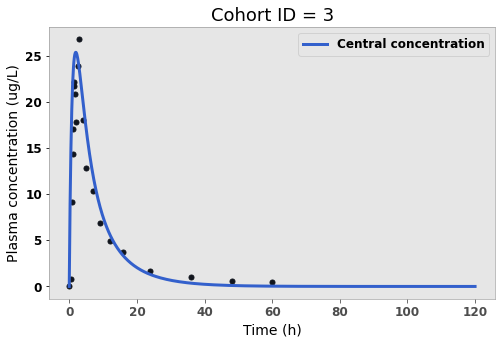

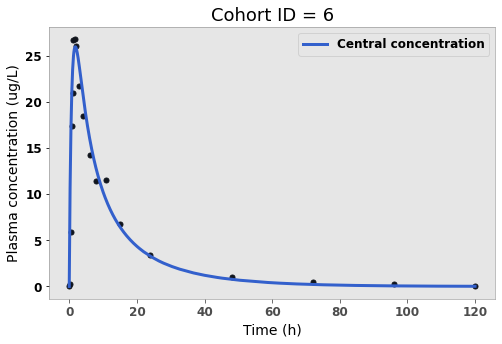

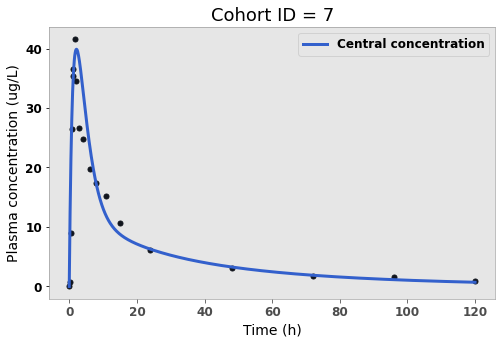

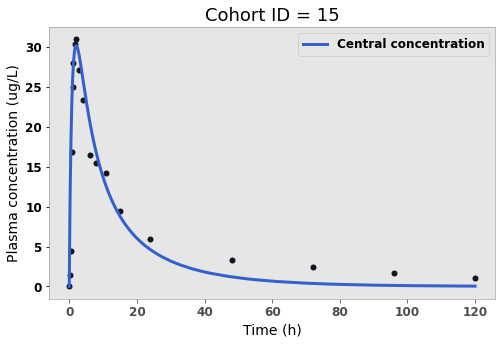

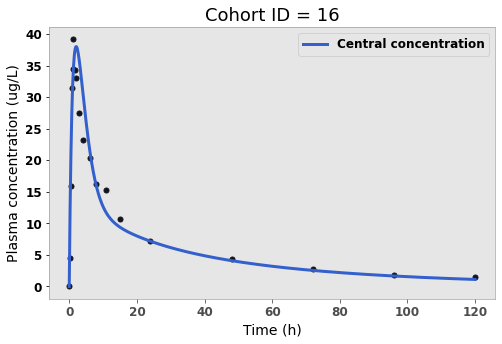

In [55]:
df_single = format_de_dataframe(de_results_single)
for subject_id in df_single.subject_id.values:
    k_values = list(df_single[df_single.subject_id == subject_id][['Bmax_k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)

### Summing it up
At this point, we have covered the key components of the project, with the above demonstration making use of data from single dose studies. 

For the sake of completeness, I have also included below the code used to run this modelling for multiple dose data. It will mostly be a repeat of the code above, with some variations to take into account the multiple trajectories created by the numerous doses (e.g. different initial concentration after each dose).

### Multi-Dose Modelling

In [4]:
# Import data for the actual concentration-time data from the clinical studies (single dose)
files = os.listdir('Data/Multiple Dosing')
files_xls = [f for f in files if f[-4:] == 'xlsx']

list_of_raw_df = []

for file in files_xls:
    data = pd.read_excel(f'Data/Multiple Dosing/{file}')
    df = pd.DataFrame(data)
    df['time'] = round(df['time'],3)
    list_of_raw_df.append(df)
    
subject_id_list = [19,20,22,23,25,26,33,36,37,39,40] # These are the subject IDs we will be looking at for the whole project

# Attaching subject ID (as the key) to each dataframe (value) in the dictionary of concentration-time data
list_of_samples = dict(zip(subject_id_list, list_of_raw_df))

In [5]:
# Identify which subject had how many doses in the multiple dosing
prior_doses = [5,7,7,7,7,5,5,5,5,7,7]
five_prior_doses = [19,26,33,36,37]
seven_prior_doses = [20,22,23,25,39,40]
subject_prior_doses = dict(zip(subject_id_list, prior_doses))

In [6]:
# Adjusting the time points based on the number of prior doses received (for multiple dosing)
for i in list_of_samples:
    if i in five_prior_doses:
        list_of_samples[i]['time'] = list_of_samples[i]['time'] + 96
    if i in seven_prior_doses:
        list_of_samples[i]['time'] = list_of_samples[i]['time'] + 144

In [7]:
for i in list_of_samples:  
    if list_of_samples[i]['time'][0] != 0.0:
        new_row = pd.DataFrame({'time':0.0, 'conc':0.0}, index =[0])
        list_of_samples[i] = pd.concat([new_row, list_of_samples[i][:]]).reset_index(drop = True)
    else:
        pass

In [8]:
list_of_samples

{19:       time       conc
 0     0.00   0.000000
 1    96.00   7.229920
 2    96.25   7.479224
 3    96.50   9.972299
 4    96.75  18.199400
 5    97.00  22.936288
 6    97.50  30.664820
 7    98.00  32.409972
 8    99.00  30.466205
 9   100.00  27.175208
 10  101.00  24.681400
 11  102.00  21.689751
 12  104.00  19.944598
 13  107.00  15.955679
 14  111.00  12.465374
 15  120.00   7.977839,
 20:        time       conc
 0     0.000   0.000000
 1   144.000   4.013010
 2   144.500   6.488490
 3   144.750  18.384400
 4   145.000  38.420200
 5   145.250  53.258500
 6   145.375  50.841700
 7   145.500  47.359200
 8   146.000  32.997200
 9   146.500  24.930800
 10  147.000  21.097900
 11  148.000  15.251700
 12  149.000  14.473600
 13  151.000  12.351300
 14  153.000   9.226700
 15  156.000   5.856920
 16  160.000   6.149090
 17  168.000   4.083840
 18  180.000   1.427170
 19  192.000   1.099180
 20  204.000   0.609200
 21  216.000   0.578815,
 22:       time       conc
 0     0.00   0.0000

In [9]:
# Bioavailability of Mirtazapine
F = 0.497 

# Number of compartments (inclusive of GI tract)
n = 3 
    
# Presumed volume of distribution for single dosing
V1_multi = df_subject_master[df_subject_master['dosing'] == 'Multiple']['V1'][5]

# Set the timepoints where repeat doses occurred
all_time_points = [0,24,48,72,96,120,144,168]

In [10]:
def dC(t, C, ka, Bmax_k12, k21, ke, KM):
    
    A, C1, C2 = C[0], C[1], C[2]
    
    dC0dt = -ka*A
    dC1dt = (ka*(A/V1_multi)) - (Bmax_k12*(C1/(KM + C1))) + k21*C2 - ke*C1
    dC2dt = (Bmax_k12*(C1 / (KM + C1))) - k21*C2

    dCdt = np.array([[dC0dt],[dC1dt],[dC2dt]]).reshape(n,)
    
    return dCdt

In [11]:
def ode_solver(p, subject_id, period_start, period_end, C_initial):
    
    ka, Bmax_k12, k21, ke = p
    KM = 14.3

    intervals = ((period_end - period_start) * 8) + 1
    
    time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], t_eval = time_horizon, 
                       y0 = C_initial, args=(ka, Bmax_k12, k21, ke, KM,))
    return output

In [12]:
def objective_func(p, subject_id):
    
    # Setup timepoints
    time_points = all_time_points[:subject_prior_doses[subject_id]] # Add the dosing time points
    final_timepoint = int(list_of_samples[subject_id]['time'].values[-1]) # Final data timepoint where trajectory ends
    time_points.append(final_timepoint)
    n_timepoints = len(time_points)
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000   
    
    C_initial = np.zeros(n)
    C_initial.reshape(n,)
    C_initial[0] = (dose_ug * F)
    C_initial[1] = list_of_samples[subject_id]['conc'][0]
    
    central_conc = []
    t_horizon = []
    
    # Create trajectory for each phase between doses
    for i in range(1,n_timepoints):
        period_start = time_points[i-1]
        period_end = time_points[i]

        output = ode_solver(p, subject_id, period_start, period_end, C_initial)
        
        central_conc = np.append(central_conc,output.y[1])
        t_horizon = np.append(t_horizon, output.t)
        
        C_initial[0] = output.y[0][-1] + (dose_ug*F)
        C_initial[1] = output.y[1][-1]
        C_initial[2] = output.y[2][-1]
        
    output_dict = dict(zip(t_horizon, central_conc))

    sample_df = list_of_samples[subject_id]
    t_sample = sample_df['time'].values
    y_pred = [output_dict[t] for t in t_sample] 
    y_actual = sample_df['conc'].values
    
    error = y_actual - y_pred
    normalized_error = error / y_actual.max()
    squared_error = np.power(normalized_error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]

    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    Cmax_actual = sample_df['conc'].max()
    Tmax_actual = sample_df.iloc[sample_df['conc'].argmax(), :1].values[0]
    Cmax_diff = np.abs(Cmax_actual - Cmax_pred)
    Tmax_diff = np.abs(Tmax_actual - Tmax_pred)
    Cmax_limit = 0.04 * Cmax_actual # Allow up to 4% variation
    Tmax_limit = 0.04 * Tmax_actual
    if Cmax_diff < Cmax_limit:
        Cmax_penalty = Cmax_diff
        Tmax_penalty = Tmax_diff
    else:
        Cmax_penalty = np.square(Cmax_diff)
        Tmax_penalty = np.square(Tmax_diff)
    total_penalty = Cmax_penalty + Tmax_penalty
    total_error = mse + (0.001 * total_penalty) # Add weights
    return total_error

In [13]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
    
    # Setup timepoints
    time_points = all_time_points[:subject_prior_doses[subject_id]] # Add the dosing time points
    final_timepoint = int(list_of_samples[subject_id]['time'].values[-1]) # Final data timepoint where trajectory ends
    time_points.append(final_timepoint)
    n_timepoints = len(time_points)
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000   
    
    C_initial = np.zeros(n)
    C_initial.reshape(n,)
    C_initial[0] = (dose_ug * F)
    C_initial[1] = list_of_samples[subject_id]['conc'][0]
    
    central_conc = []
    peripheral_conc = []
    t_horizon = []
    
    for i in range(1,n_timepoints):
        period_start = time_points[i-1]
        period_end = time_points[i]

        output = ode_solver(p, subject_id, period_start, period_end, C_initial)
        
        central_conc = np.append(central_conc,output.y[1])
        peripheral_conc = np.append(peripheral_conc,output.y[2])
        t_horizon = np.append(t_horizon, output.t)
        
        C_initial[0] = output.y[0][-1] + (dose_ug*F)
        C_initial[1] = output.y[1][-1]
        C_initial[2] = output.y[2][-1]
    
    plt.figure(figsize=(10,5))
    plt.xlabel('Time (h)')
    plt.ylabel('Plasma concentration (ug/L)')
    plt.title(f'Cohort ID = {subject_id}')
    plt.plot(t_horizon,central_conc, color = color_scheme[1], label = 'Central concentration')
    #plt.plot(t_horizon,peripheral_conc, color = color_scheme[2], label = 'Peripheral concentration')
    print(f'Central Cmax = {np.amax(output.y[1])}, Peripheral Cmax = {np.amax(output.y[2])}')
    plt.legend()
    plt.scatter(list_of_samples[subject_id]['time'], list_of_samples[subject_id]['conc'], color = color_scheme[0], s = 25)


In [17]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'Bmax_k12'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[3])
    df_de_results.loc[:, 'KM'] = 14.3
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

In [14]:
#  ka, Bmax_k12, k21, ke
bounds = [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]

In [19]:
de_results_multi = []

for subject_id in subject_id_list:
        start = time.perf_counter()
        best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 16,
                                             recombination=0.8, mutation = (0,1), maxiter = 1000, tol = 0.0003,
                                             args = (subject_id,), seed = 42)
        de_results_multi.append([subject_id, best_result.x, best_result.fun, bounds])
        
        finish = time.perf_counter()
        print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
        print(best_result.x, best_result.fun)
        print(f'Bounds: {bounds}')

19 DE completed in 36.45 seconds
[ 0.41583494 13.82652309  0.24499003  0.19236895] 0.00920868534208658
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
20 DE completed in 127.19 seconds
[ 2.05945536 13.60416919  0.05349716  0.23764688] 0.048772670849170315
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
22 DE completed in 54.77 seconds
[ 0.6823835  38.72352855  0.31849215  0.26288458] 0.010516963991843504
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
23 DE completed in 66.69 seconds
[ 0.26833778 33.32194727  0.16538193  0.14489667] 0.011346271167744162
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
25 DE completed in 58.13 seconds
[ 0.5032964  31.78012556  0.21324209  0.259553  ] 0.013693515865455174
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
26 DE completed in 27.78 seconds
[ 0.38676336 24.98430749  0.23450184  0.17128912] 0.008626249076846833
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
33 DE completed 

Central Cmax = 31.75149918362806, Peripheral Cmax = 33.17973371475426
Central Cmax = 51.12817797790294, Peripheral Cmax = 103.39588731940376
Central Cmax = 38.63908784771847, Peripheral Cmax = 72.80122917786159
Central Cmax = 41.856614268011455, Peripheral Cmax = 137.05779324517036
Central Cmax = 57.851799666605224, Peripheral Cmax = 98.84076554571898
Central Cmax = 68.06094185346414, Peripheral Cmax = 80.10257112906913
Central Cmax = 97.22992793490134, Peripheral Cmax = 140.0271413371642
Central Cmax = 128.89426593815315, Peripheral Cmax = 322.4552624649299
Central Cmax = 151.08033519129353, Peripheral Cmax = 500.3589679814662
Central Cmax = 48.765438560221426, Peripheral Cmax = 168.6657665634846
Central Cmax = 52.88888816276326, Peripheral Cmax = 235.8038157554906


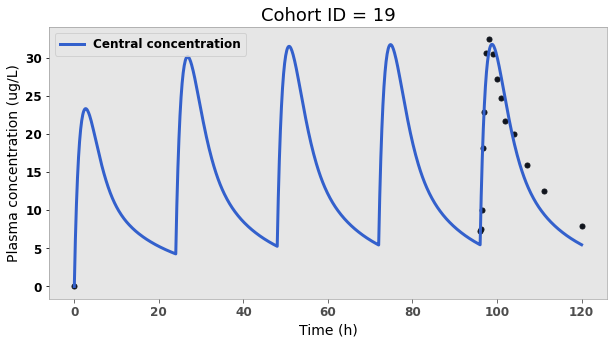

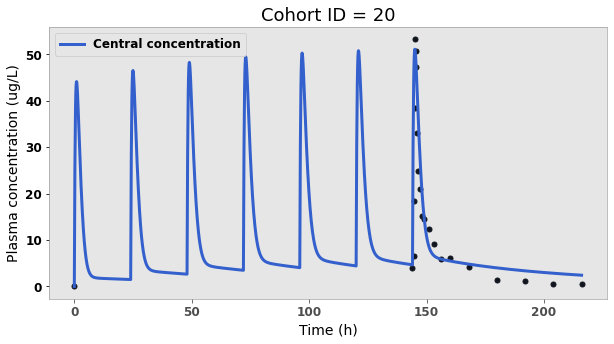

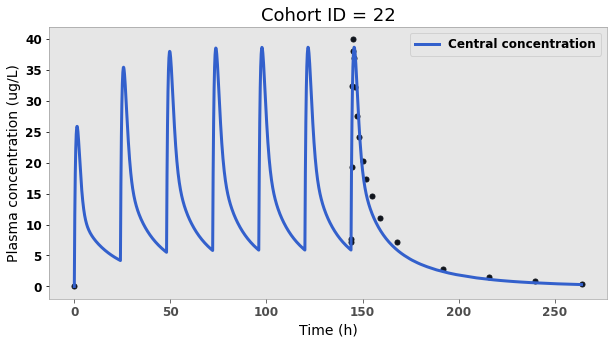

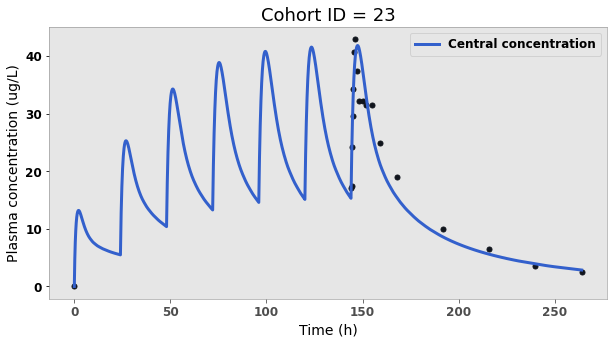

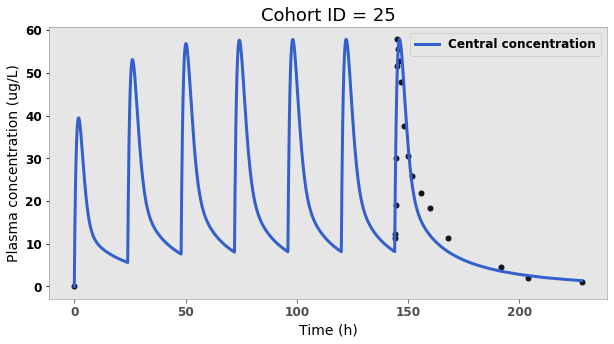

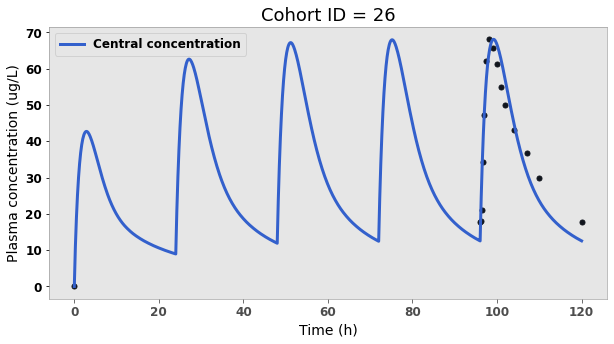

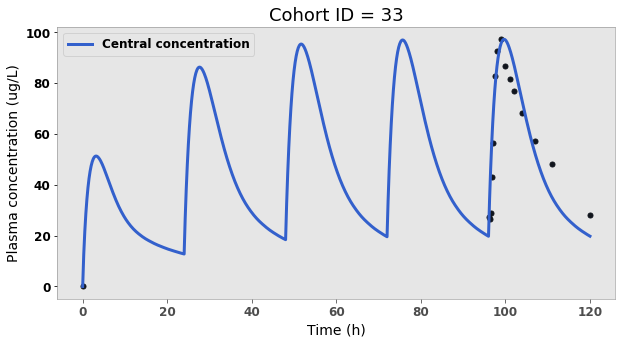

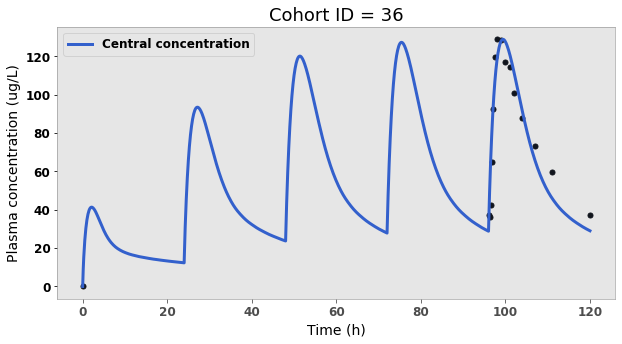

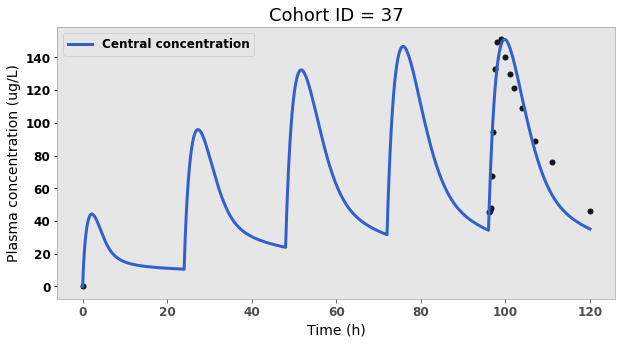

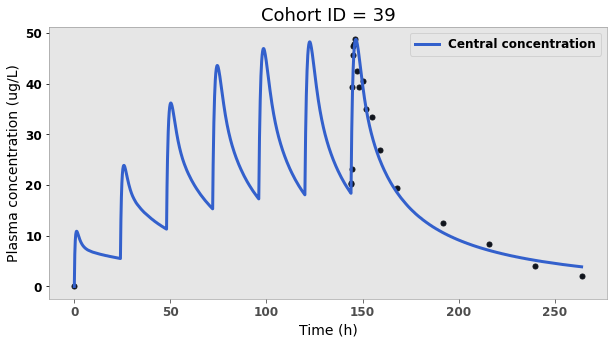

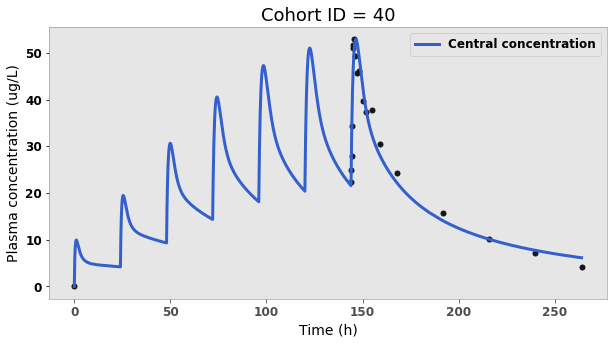

In [20]:
# Plot the trajectories
df_multi = format_de_dataframe(de_results_multi)
for subject_id in df_multi.subject_id.values:
    k_values = list(df_multi[df_multi.subject_id == subject_id][['ka','Bmax_k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)